## Sanity check with KNN on fasttext embeddings of edges in a graph

In [1]:
import fasttext
from pathlib import Path
from ApexDAG.nn.training import GraphEncoder 
from ApexDAG.util.logging import setup_logging


logger = setup_logging("main", True)
encoded_checkpoint_path = Path("data/raw/pytorch-encoded-finetune")
graph_encoder = GraphEncoder(encoded_checkpoint_path, 
                                 logger, 
                                 2, 
                                 3, 
                                 True)

graphs_encoded = graph_encoder.reload_encoded_graphs()

/data/anaconda/envs/nina/apexdag/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-04-01 20:37:50,768 | main | INFO | Loading encoded graphs...
Loading encoded graphs: 100%|██████████| 660/660 [00:00<00:00, 1243.13it/s]


In [2]:
fasttext_model = fasttext.load_model("cc.en.300.bin")

def embed(sentence: str):
    return fasttext_model.get_sentence_vector(sentence)

In [ ]:
import numpy as np

edge_embeddings = np.empty((0, 300))  # Assuming edge features have a fixed dimension
edge_type_labels = []

for graph in graphs_encoded:
    edge_types = graph['edge_types']
    
    valid_mask = edge_types != -1
    
    edge_types = edge_types[valid_mask]
    edge_type_labels.extend(edge_types)
    
    graph_edge_embeddings = graph['edge_features'][valid_mask]
    edge_embeddings = np.vstack((edge_embeddings, graph_edge_embeddings))  # Concatenate along rows

    
edge_embeddings = np.array(edge_embeddings)
edge_labels = np.array(edge_type_labels)

### Let's try the KNN classifier!  - this is an upper bound since this is a non-parametric classifier

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(edge_embeddings, edge_labels, test_size=0.2, random_state=42)


In [7]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier


knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("Predicted labels:", y_pred)
print("True labels:", y_test)

Accuracy: 0.51
Predicted labels: [1 5 5 ... 1 0 5]
True labels: [5 5 5 ... 1 0 6]


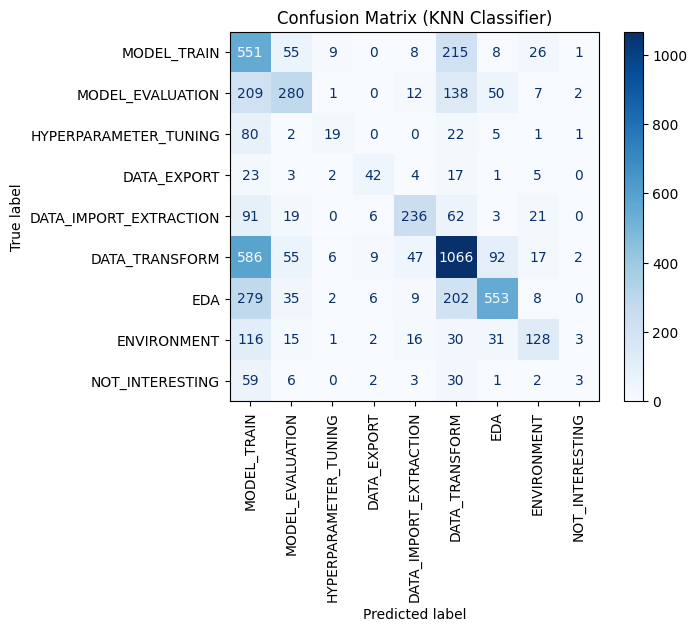

In [8]:
from sklearn.metrics import  confusion_matrix, ConfusionMatrixDisplay
from ApexDAG.sca.constants import REVERSE_DOMAIN_EDGE_TYPES
import matplotlib.pyplot as plt

descriptive_labels = [REVERSE_DOMAIN_EDGE_TYPES[label] for label in knn.classes_]

cm = confusion_matrix(y_test, y_pred, labels=knn.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=descriptive_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (KNN Classifier)")
plt.xticks(rotation=90)
plt.show()

### Let's try a parametric model:NN

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim


class SimpleLinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleLinearModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
    
    def forward(self, x):
        return self.linear(x)

input_size = 300  # Number of input features
output_size = 9   # Number of output classes
learning_rate = 0.01
num_epochs = 50

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

model = SimpleLinearModel(input_size, output_size)
criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


Accuracy: 0.47
Predicted labels: [5 5 5 ... 1 5 5]
True labels: [5 5 5 ... 1 0 6]


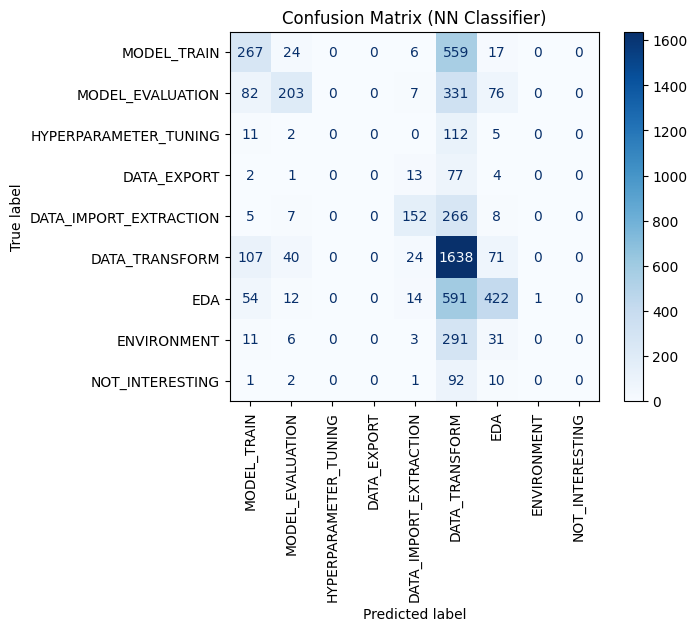

In [13]:
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)
    y_pred = torch.argmax(y_pred_tensor, dim=1).numpy()
    accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("Predicted labels:", y_pred)
print("True labels:", y_test)

cm = confusion_matrix(y_test, y_pred, labels=knn.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=descriptive_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (NN Classifier)")
plt.xticks(rotation=90)
plt.show()